In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
from time import time

from astropy.table import Table, vstack

import numpy as np 
import emcee

import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.patches as patches

from astroML.stats import binned_statistic_2d

from cap_loess_2d import loess_2d
from cap_plot_velfield import plot_velfield

from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree

plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)
    
from asap.stellar_mass_function import get_smf_bootstrap
from asap.asap_data_io import *
from asap.asap_model_setup import *
from asap.asap_utils import *
from asap.asap_run_model import * 
from asap.asap_model_prediction import *
from asap.asap_likelihood import * 
from asap.um_model_plot import *
from asap.full_mass_profile_model import *
from asap.asap_mass_model import * 
from asap.asap_model_prediction import asap_predict_mhalo 

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from hsc_massive.smhm import * 

from palettable.cartocolors.qualitative import Safe_10, Vivid_10
color_circle = Safe_10.mpl_colors
color_circle_2 = Vivid_10.mpl_colors

### Load model and data

In [3]:
test_dir = 'test'

model_str = 'asap_mmax_m10_frac4_test_C'

config_file = os.path.join(test_dir, model_str + '.yaml')

burnin_file = os.path.join(test_dir, model_str + '_burnin.npz')
result_file = os.path.join(test_dir, model_str + '_run.npz')

cfg_ini = parse_config(config_file)

cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

print(cfg['model_type'])

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin7_default
# Pre-computed SMF for inner logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.6.npy
# Pre-computed SMF for total logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_m10_cov.npy
# Using logm_10 as inner stellar mass.
# Using logm_max as total stellar mass.
# There are 12 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.6000 -- 12.3000 in 7 bins
# SMF for inner stellar mass: 
  10.8000 -- 11.8000 in 10 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.60 < logMtot < 12.30
# The volu

In [4]:
um_mock = um_data['um_mock']

### New model

* Greymalkin
* Using `logmh_host`
* `stretch` move, `a=4`
* 256 Walkers, 500 burn-in, 500 steps

In [5]:
(mod_burnin_samples, 
 mod_burnin_chains, 
 mod_burnin_lnprob, 
 mod_burnin_best, _, _) = mcmc_load_results(burnin_file)

(mod_result_samples, 
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = mcmc_load_results(result_file)

print(np.nanmax(mod_burnin_lnprob), mod_burnin_best)
print(np.nanmax(mod_result_lnprob), mod_result_best)

# This is not perfect
last_1_step = np.vstack([chain[-1:] for chain in mod_result_chains])
last_2_step = np.vstack([chain[-50] for chain in mod_result_chains])
last_3_step = np.vstack([chain[-100] for chain in mod_result_chains])
last_4_step = np.vstack([chain[-200] for chain in mod_result_chains])

last_1_step = last_1_step[np.isfinite(mod_result_lnprob[-1])]
last_2_step = last_2_step[np.isfinite(mod_result_lnprob[-50])]
last_3_step = last_3_step[np.isfinite(mod_result_lnprob[-100])]
last_4_step = last_4_step[np.isfinite(mod_result_lnprob[-200])]

last_step = np.vstack([last_1_step, last_2_step, last_3_step, last_4_step])

(-236.45809287458331, array([ 0.59991689,  3.72834432,  0.05534037,  0.13370438,  0.60908183,
       -0.18592197,  0.08673199]))
(-237.0652431145963, array([ 0.60667654,  3.64003706,  0.05269032,  0.126368  ,  0.61686872,
       -0.17985394,  0.08939318]))


In [6]:
from astropy.stats import sigma_clip

mod_samples_clip = sigma_clip(mod_result_samples, 1.0, 
                              cenfunc=np.nanmedian, stdfunc=np.nanstd, axis=0)

/usr/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


#### Corner plot

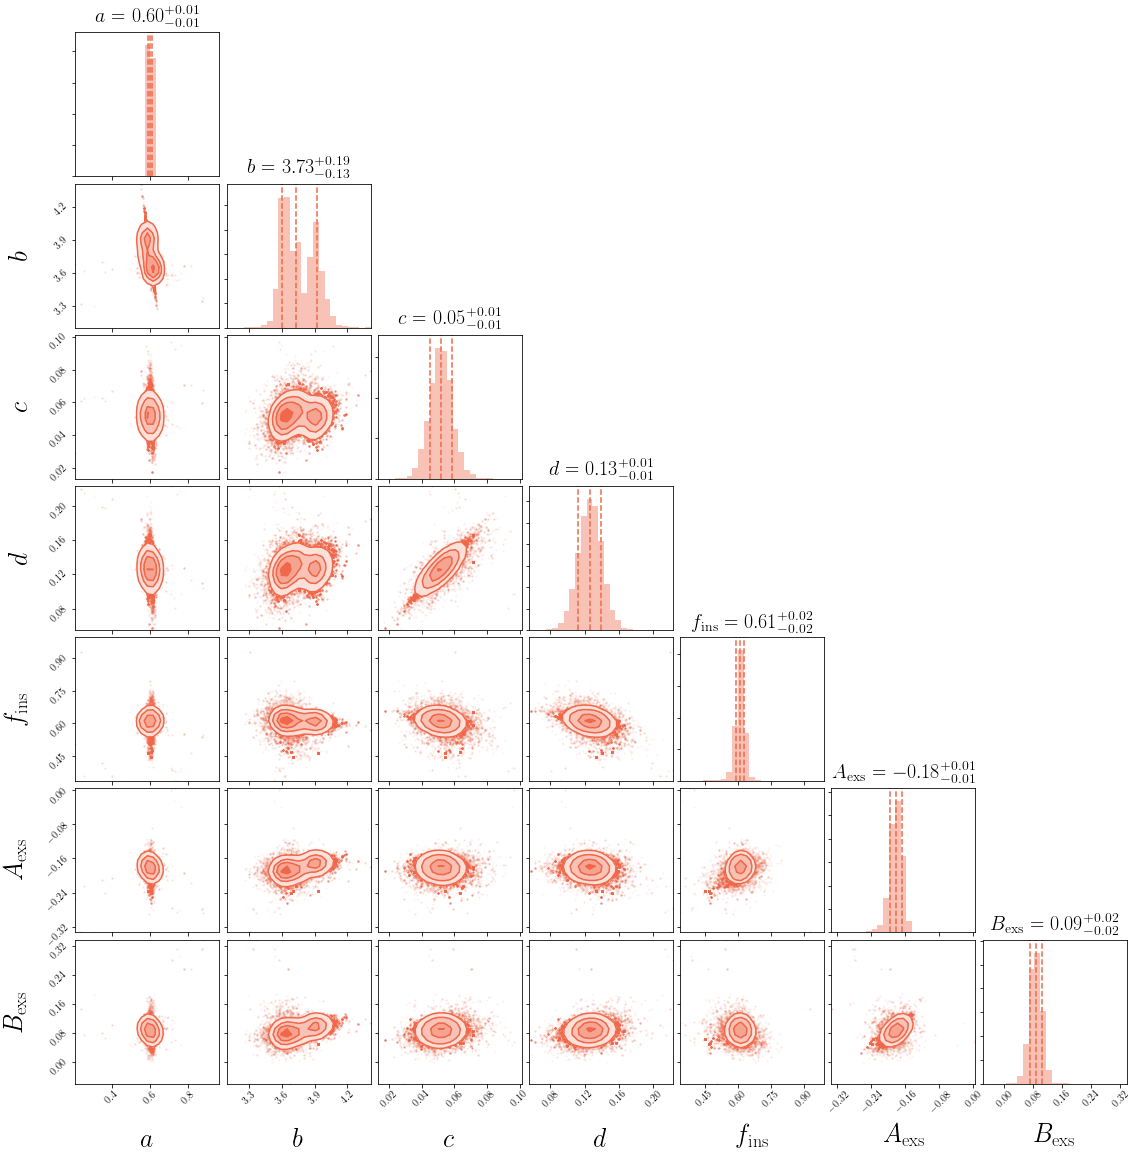

In [7]:
frac4_label = [r'$a$', r'$b$', r'$c$', r'$d$', 
               r'$f_{\rm ins}$', r'$A_{\rm exs}$', r'$B_{\rm exs}$']

mod_corner = plot_mcmc_corner(mod_result_samples, frac4_label)

In [85]:
mod_corner.savefig(os.path.join('fig', model_str + '_corner.pdf'), dpi=120)

#### Trace plot

/usr/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


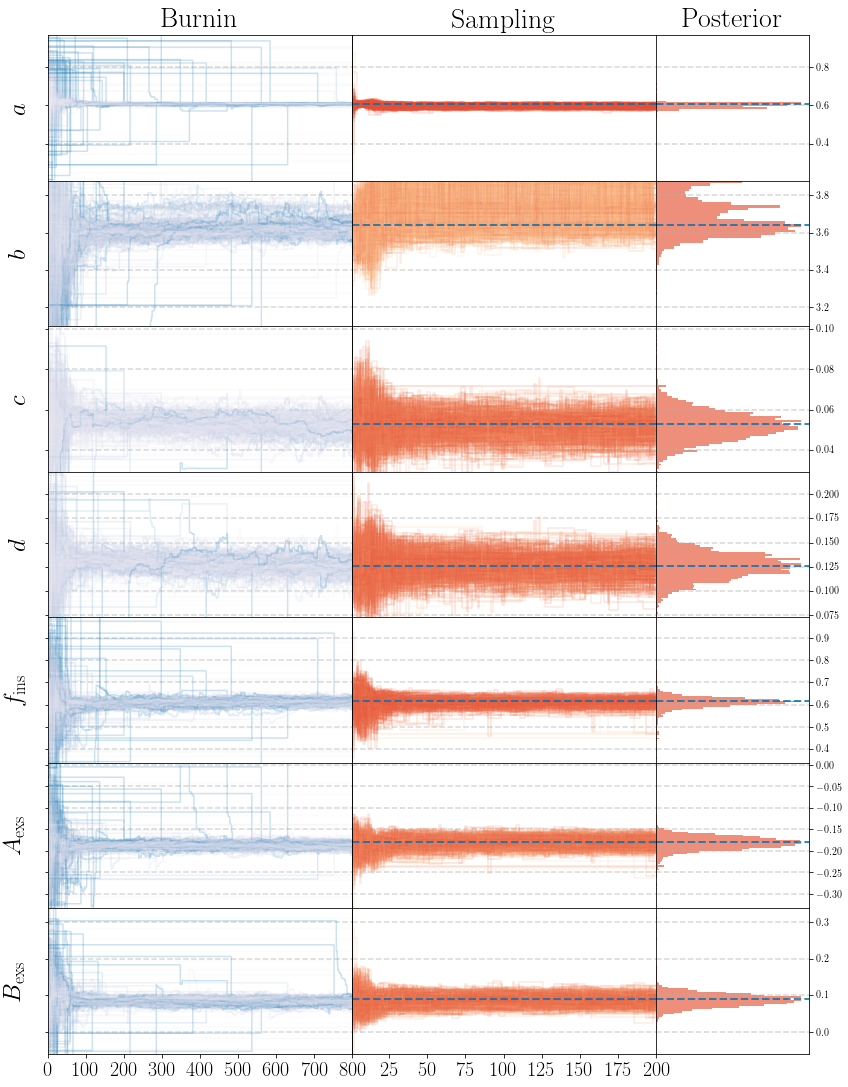

In [8]:
mod_trace = plot_mcmc_trace(mod_result_chains, 
                            frac4_label,
                            mcmc_best=mod_result_best,
                            mcmc_burnin=mod_burnin_chains)

In [9]:
mod_trace.savefig(os.path.join('fig', model_str + '_trace.pdf'), dpi=120)

### Best-fit model

In [10]:
mod_model_prob = asap_predict_model_prob(mod_result_best, cfg, obs_data, um_data,  
                                         show_smf=False, show_dsigma=False, return_all=True)

um_smf_tot, um_smf_inn, um_dsigma, logms_mod_inn, logms_mod_tot, sig_logm, mask_tot = mod_model_prob

In [11]:
mod_model = asap_predict_model(mod_result_best, cfg, 
                               obs_data, um_data, show_smf=False, return_all=True)

(um_smf_tot, um_smf_inn, um_dsigma, 
 logms_inn_mod_all, logms_tot_mod_all, 
 logms_halo_mod_all, mask_tot) = mod_model

#### SMF plot with scatter included

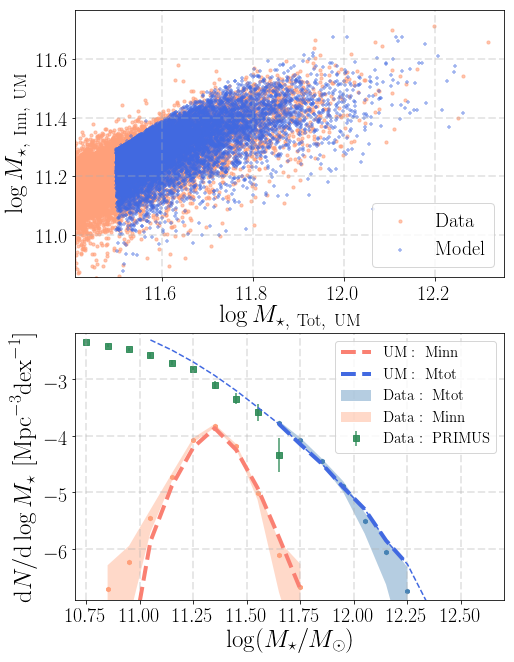

In [12]:
um_smf_tot_all = get_smf_bootstrap(logms_tot_mod_all, cfg['um_volume'],
                                   20, 10.5, 12.5, n_boots=1)

mod_smf = plot_mtot_minn_smf(obs_data['obs_smf_tot'], obs_data['obs_smf_inn'],
                             obs_data['obs_mtot'], obs_data['obs_minn'],
                             um_smf_tot, um_smf_inn,
                             logms_mod_tot, logms_mod_inn,
                             obs_smf_full=obs_data['obs_smf_full'],
                             um_smf_tot_all=um_smf_tot_all[5:],
                             not_table=True)

In [87]:
mod_smf.savefig(os.path.join('fig', model_str + '_smf.pdf'), dpi=120)

#### Delta-Sigma Profiles

In [83]:
mod_model_prob = asap_predict_model_prob(mod_result_best, cfg, obs_data, um_data,  
                                         show_smf=False, show_dsigma=False, return_all=True)

um_smf_tot, um_smf_inn, um_dsigma, logms_mod_inn, logms_mod_tot, sig_logm, mask_tot = mod_model_prob

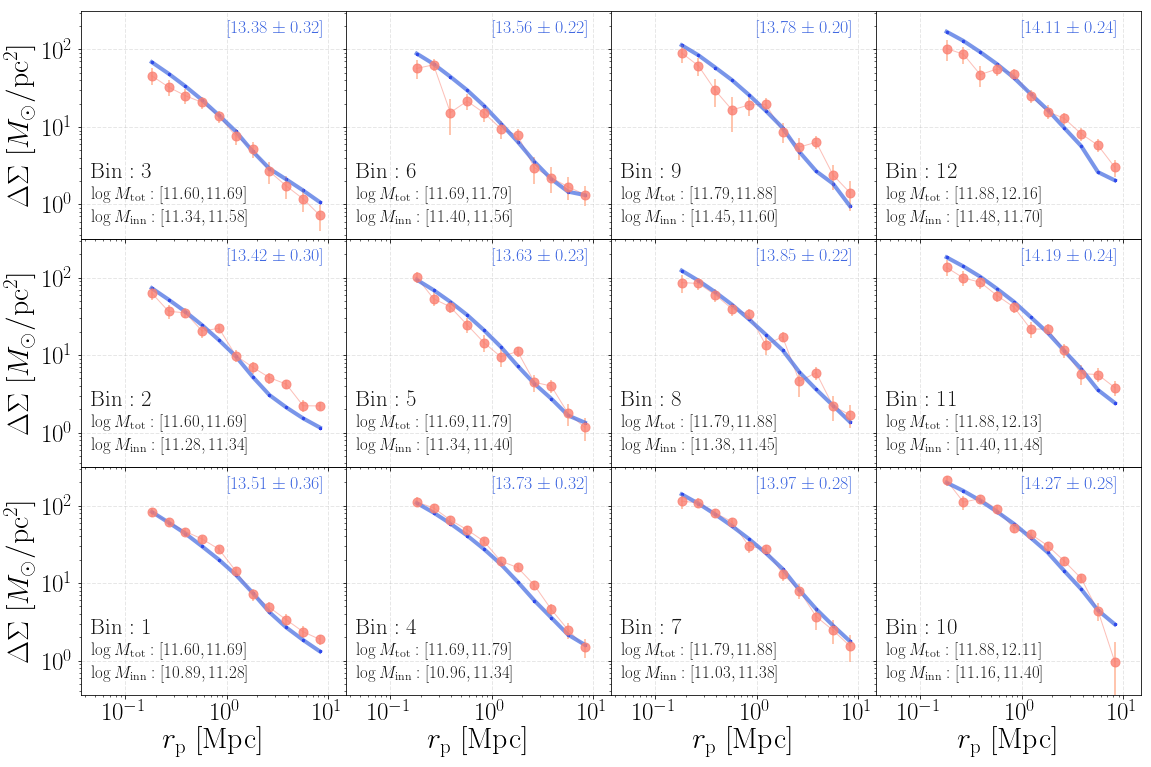

In [84]:
um_mhalo_tuple = asap_predict_mhalo(obs_data['obs_wl_dsigma'], um_data['um_mock'][mask_tot],
                                    logms_mod_tot, logms_mod_inn)

mod_dsig = plot_dsigma_profiles(obs_data['obs_wl_dsigma'],
                                um_dsigma, obs_mhalo=None, um_mhalo=um_mhalo_tuple)

In [88]:
mod_dsig.savefig(os.path.join('fig', model_str + '_dsig.pdf'), dpi=120)

#### Iso-halo mass trend

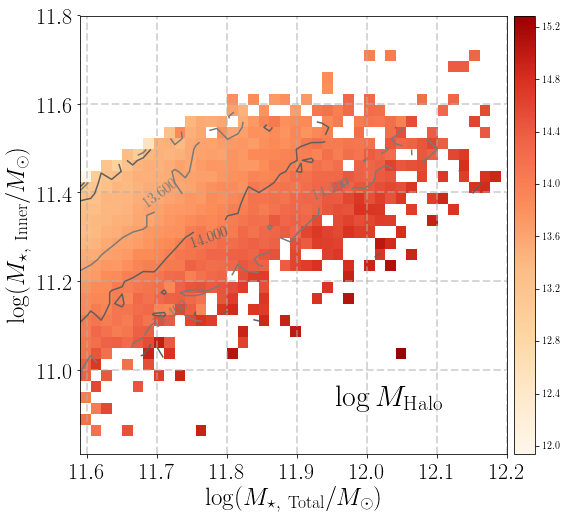

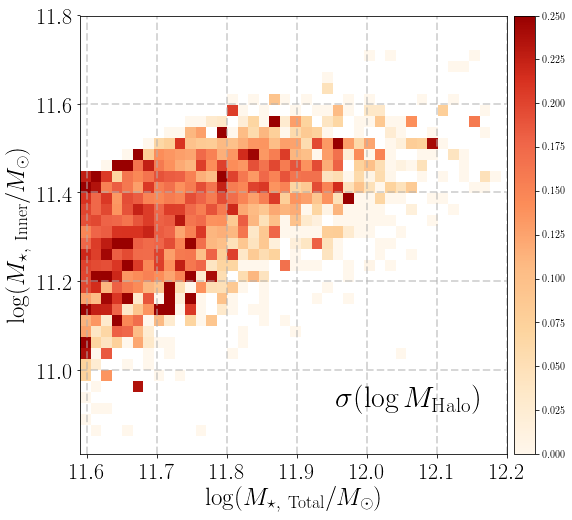

In [89]:
xx = logms_tot_mod_all
yy = logms_inn_mod_all
zz = um_mock['logmh_peak']

# Median halo mass
mod_mhalo = plot_mtot_minn_trend(xx, yy, zz, method=np.mean, 
                                 x_bins=40, y_bins=35,
                                 x_lim=[11.59, 12.2], y_lim=[10.81, 11.799],
                                 n_contour=9)

# Scatter
mod_sigmh = plot_mtot_minn_trend(xx, yy, zz, method=np.nanstd, contour=False,
                                 x_bins=40, y_bins=35,
                                 x_lim=[11.59, 12.2], y_lim=[10.81, 11.799], 
                                 title=r'$\sigma(\log M_{\mathrm{Halo}})$',
                                 z_max=0.25)

mod_mhalo.savefig(os.path.join('fig', model_str + '_mtot_minn_mhalo.pdf'), dpi=120)
mod_sigmh.savefig(os.path.join('fig', model_str + '_mtot_minn_sigmh.pdf'), dpi=120)

#### Best-fit halo mass relation

In [45]:
shmr_a, shmr_b = mod_result_best[0], mod_result_best[1]
sigms_a, sigms_b = mod_result_best[2], mod_result_best[3]

mask_cen = um_mock['upid'] == -1
print(mask_cen.sum())

logmh_peak = um_mock['logmh_peak']
logmh_peak_cen = um_mock[mask_cen]['logmh_peak']

logmh_bin = np.linspace(12.0, 14.8, 10)

# For central
idx_logmh_cen = np.digitize(logmh_peak_cen, logmh_bin)
logmh_cen_avg = [np.nanmean(logmh_peak_cen[idx_logmh_cen == k])
                 for k in range(len(logmh_bin))]
logms_cen_avg = [np.nanmean(logms_halo_mod_all[mask_cen][idx_logmh_cen == k])
                for k in range(len(logmh_bin))]
logms_cen_sig = [np.nanstd(logms_halo_mod_all[mask_cen][idx_logmh_cen == k])
                for k in range(len(logmh_bin))]

372240


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


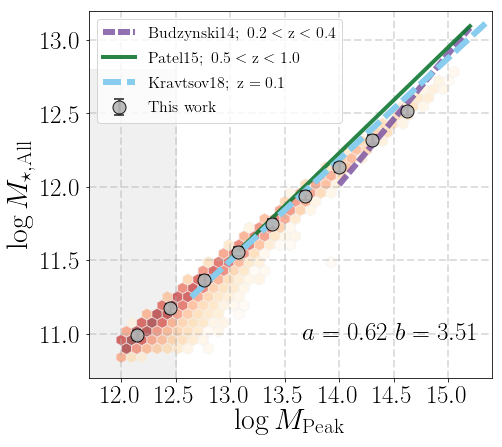

In [46]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.195, right=0.995,
                    bottom=0.145, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
ax1.fill_between([11.50, 12.50], [10.50, 10.5], [12.8, 12.8],
                 color=BLK(0.2), edgecolor=BLK(0.4), alpha=0.5)

ax1.hexbin(logmh_peak_cen, logms_halo_mod_all[mask_cen], 
           gridsize=[35, 18], cmap='OrRd', edgecolor=BLK(0.1), 
           alpha=0.6, mincnt=2, bins='log')

logms_arr = np.linspace(11.5, 14.0, 100)

# Hilton + 2013
#ax1.plot(14.86 + 0.9 * (logms_arr - 13.18) + m500c_to_m200c(),
#         logms_arr + imf_corr_to_chab(kind='salpeter'),
#         c=color_circle_2[8], linewidth=5, alpha=0.8, 
#         label=r'$\mathrm{Hilton13;\ 0.3<z<1.0}$')

# van der Burg + 2014
#ax1.plot(logmh_arr,
#         0.59 * (logmh_arr - 14.15) + 12.44,
#         c=color_circle_2[8], linewidth=5, alpha=0.8, 
#         label=r'$\mathrm{van\ der\ Burg14;\ z=1.0}$')

# Budzynski + 2014
logmh_arr = np.linspace(14.0, 15.2, 100)
ax1.plot(logmh_arr,
         0.89 * (logmh_arr - np.log10(3.0E14)) + 12.44,
         c=color_circle_2[8], linewidth=6, alpha=0.8, 
         label=r'$\mathrm{Budzynski14;\ 0.2<z<0.4}$',
         linestyle='--', dashes=[2,0.5])

# Patel + 2015; 
logmh_arr = np.linspace(13.0, 15.2, 100)
ax1.plot(logmh_arr,
         0.72 * logmh_arr + 2.20 + imf_corr_to_chab(kind='kroupa'),
         c=color_circle[3], linewidth=4, alpha=0.9, 
         label=r'$\mathrm{Patel15;\ 0.5<z<1.0}$',
         linestyle='-')

# Kravtsov + 2018
logmh_arr = np.linspace(12.5, 15.2, 100)
ax1.plot(logmh_arr + m500c_to_m200c(), 
         kravtsov18_m500_to_mbcg(logmh_arr, tot=True) + 0.05 + sps_corr_to_bc03(kind='pegase'),
         c=color_circle[0], linewidth=6, alpha=1.0, 
         label=r'$\mathrm{Kravtsov18;\ z=0.1}$',
         linestyle='--', dashes=[3,1])

    
#logmh_cen = np.linspace(11.5, 15.5, 50)
#ax1.plot(logmh_cen, shmr_a * logmh_cen + shmr_b,
#         linewidth=5.0, linestyle='--', alpha=0.9, 
#         c=BLU(0.8))

ax1.errorbar(logmh_cen_avg, logms_cen_avg, yerr=np.asarray(logms_cen_sig) / 2.0, fmt='o', 
             ecolor=BLK(0.8), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.4), markersize=13, alpha=0.9,
             markeredgecolor=BLK(1.0), label=r'$\mathrm{This\ work}$')

ax1.text(0.75, 0.09, r"$a=%5.2f\ b=%5.2f$" % (shmr_a, shmr_b),
         verticalalignment='bottom',
         horizontalalignment='center',
         fontsize=25,
         transform=ax1.transAxes)

ax1.legend(loc='upper left', fontsize=16)

ax1.set_xlim(11.7, 15.4)
ax1.set_ylim(10.7, 13.2)

ax1.set_xlabel(r'$\log M_{\mathrm{Peak}}$', fontsize=30)
ax1.set_ylabel(r'$\log M_{\star, \rm All}$', fontsize=30)

fig.savefig(os.path.join('fig', model_str + '_shmr_all.pdf'), dpi=150)

In [47]:
logmh_bin = np.linspace(12.5, 15.0, 7)

# For central
idx_logmh_cen = np.digitize(logmh_peak_cen, logmh_bin)

logmh_cen_avg = [np.nanmean(logmh_peak_cen[idx_logmh_cen == k])
                 for k in range(len(logmh_bin))]

logms_cen_avg = [np.nanmean(logms_tot_mod_all[mask_cen][idx_logmh_cen == k])
                for k in range(len(logmh_bin))]

logms_cen_sig = [np.nanstd(logms_tot_mod_all[mask_cen][idx_logmh_cen == k])
                for k in range(len(logmh_bin))]

In [48]:
logms_bin = np.linspace(11.4, 12.2, 8)

# For central
idx_logms_cen = np.digitize(logms_tot_mod_all[mask_cen], logms_bin)

logms_cen_avg_2 = [np.nanmean(logms_tot_mod_all[mask_cen][idx_logms_cen == k])
                   for k in range(len(logms_bin))]

logmh_cen_avg_2 = [np.nanmean(logmh_peak_cen[idx_logms_cen == k])
                   for k in range(len(logms_bin))]

logms_cen_sig_2 = [np.nanstd(logmh_peak_cen[idx_logms_cen == k])
                   for k in range(len(logms_bin))]

11.59479441143696 -1.7586819650465169 1.950678487725293 3.359137812415764 0.5038279570011127


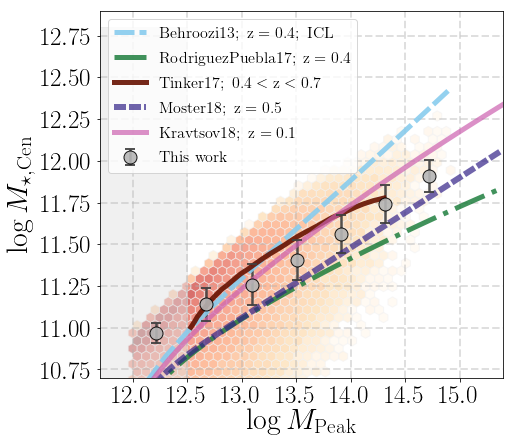

In [49]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.195, right=0.995,
                    bottom=0.145, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.hexbin(logmh_peak_cen, logms_tot_mod_all[mask_cen], 
           gridsize=[40, 37], cmap='OrRd', edgecolor=BLK(0.1), 
           alpha=0.6, mincnt=2, bins='log')

ax1.fill_between([11.50, 12.50], [10.50, 10.5], [12.8, 12.8],
                 color=BLK(0.2), edgecolor=BLK(0.4), alpha=0.5)
    
#logmh_cen = np.linspace(11.5, 15.0, 50)
#ax1.plot(logmh_cen, shmr_a * logmh_cen + shmr_b,
#         linewidth=5.0, linestyle='--', alpha=0.8)

logms_arr = np.linspace(11.4, 12.4, 100)
logmh_arr = np.linspace(11.4, 15.4, 100)
tinker17_mh_to_ms, tinker17_ms_to_mh = tinker17_shmr()
b13_icl_z1, b13_icl_z2, b13_icl_z3, b13_icl_z4 = behroozi_mh_to_ms_icl()

# Behroozi + 2013; with ICL
ax1.plot(b13_icl_z3['col1'], b13_icl_z3['col3'] + 0.05,
         linewidth=5, alpha=0.9, 
         label=r'$\mathrm{Behroozi13;\ z=0.4;\ ICL}$',
         c=color_circle[0], linestyle='--', dashes=[4,1])

# Rodriguez-Puebla + 2015; red galaxies
#ax1.plot(logmh_arr, 
#         puebla15_mh_to_ms(logmh_arr, kind='red') + 0.05,
#         linewidth=3, alpha=0.8, 
#         label=r'$\mathrm{RodriguezPuebla15;\ z=0.1;\ Red}$',
#         c=color_circle[1])

# Rodriguez-Puebla + 2017
ax1.plot(logmh_arr + np.log10(small_h_corr(0.678, mh=True)), 
         puebla17_mh_to_ms(logmh_arr, redshift=0.4) + np.log10(small_h_corr(0.678)) + 0.05,
         linewidth=5, alpha=0.8, label=r'$\mathrm{RodriguezPuebla17;\ z=0.4}$',
         c=color_circle[3], linestyle='-.')

# Tinker + 2017
ax1.plot(tinker17_mh_to_ms['logmh'], 
         tinker17_mh_to_ms['logms'] + imf_corr_to_chab(kind='kroupa') + 0.05, 
         linewidth=5, alpha=0.9, label=r'$\mathrm{Tinker17;\ 0.4<z<0.7}$',
         c=color_circle[9], linestyle='-')

# Moster + 2018
ax1.plot(logmh_arr + np.log10(small_h_corr(0.678, mh=True)), 
         moster18_mh_to_ms(logmh_arr, redshift=0.50) + np.log10(small_h_corr(0.678)) + 0.05, 
         linewidth=6, alpha=0.7, label=r'$\mathrm{Moster18;\ z=0.5}$',
         c=color_circle[4], linestyle='--', dashes=[2,0.5])

# Kravtsov + 2018
ax1.plot(logmh_arr + m500c_to_m200c(), 
         kravtsov18_mh_to_ms(logmh_arr, kind='200c', scatter=True) + 0.05 + sps_corr_to_bc03(kind='pegase'), 
         linewidth=5, alpha=0.7, label=r'$\mathrm{Kravtsov18;\ z=0.1}$',
         c=color_circle_2[4], linestyle='-')

# This work
ax1.errorbar(logmh_cen_avg, logms_cen_avg, yerr=np.asarray(logms_cen_sig) / 2.0, fmt='o', 
             ecolor=BLK(0.8), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.4), markersize=13, alpha=0.9,
             markeredgecolor=BLK(1.0), label=r'$\mathrm{This\ work}$')

ax1.legend(loc='upper left', fontsize=16)

ax1.set_xlim(11.7, 15.4)
ax1.set_ylim(10.7, 12.9)

ax1.set_xlabel(r'$\log M_{\mathrm{Peak}}$', fontsize=30)
ax1.set_ylabel(r'$\log M_{\star, \rm Cen}$', fontsize=30)

fig.savefig(os.path.join('fig', model_str + '_shmr_cen.pdf'), dpi=150)

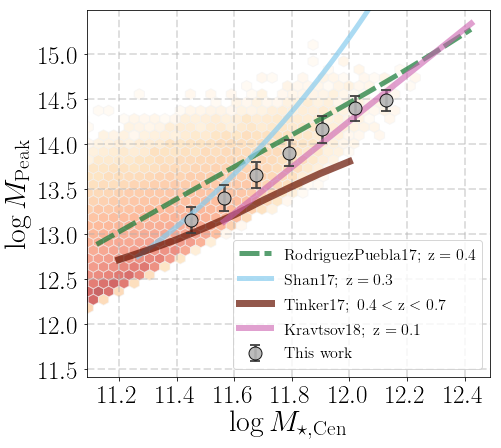

In [22]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.195, right=0.995,
                    bottom=0.145, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.hexbin(logms_tot_mod_all[mask_cen], logmh_peak_cen, 
           gridsize=[100, 18], cmap='OrRd', edgecolor=BLK(0.1), 
           alpha=0.6, mincnt=2, bins='log')

#ax1.fill_between([11.50, 12.50], [10.50, 10.5], [12.8, 12.8],
#                 color=BLK(0.2), edgecolor=BLK(0.4), alpha=0.5)
    
logms_arr = np.linspace(11.1, 12.4, 100)
logmh_arr = np.linspace(11.4, 15.4, 100)
tinker17_mh_to_ms, tinker17_ms_to_mh = tinker17_shmr()
b13_icl_z1, b13_icl_z2, b13_icl_z3, b13_icl_z4 = behroozi_mh_to_ms_icl()


# Rodriguez-Puebla + 17
ax1.plot(logms_arr + np.log10(small_h_corr(0.678)) + 0.05, 
         puebla17_ms_to_mh(logms_arr, redshift=0.4) + np.log10(small_h_corr(0.678, mh=True)),
         linewidth=5, alpha=0.7, label=r'$\mathrm{RodriguezPuebla17;\ z=0.4}$',
         c=color_circle[3], linestyle='--', dashes=[4,1])

# Shan + 2017
ax1.plot(logms_arr + 0.05 + imf_corr_to_chab(kind='kroupa') + sps_corr_to_bc03(kind='m05') + np.log10(small_h_corr(0.673)),
         shan17_ms_to_mh(logms_arr, redshift=0.3) + np.log10(small_h_corr(0.673, mh=True)),
         linewidth=5, alpha=0.7, label=r'$\mathrm{Shan17;\ z=0.3}$',
         c=color_circle[0])

# Tinker + 2017
ax1.plot(tinker17_ms_to_mh['logms'] + imf_corr_to_chab(kind='kroupa') + 0.05, 
         tinker17_ms_to_mh['logmh'],
         linewidth=7, alpha=0.7, label=r'$\mathrm{Tinker17;\ 0.4<z<0.7}$',
         c=color_circle[9], linestyle='-')

# Kravtsov + 2018
logmh_1 = np.linspace(13.0, 15.2, 100)
ax1.plot(kravtsov18_m500_to_mbcg(logmh_1) + 0.05 + sps_corr_to_bc03(kind='pegase'), 
         logmh_1 + m500c_to_m200c(),
         linewidth=6, alpha=0.6, label=r'$\mathrm{Kravtsov18;\ z=0.1}$',
         c=color_circle_2[4], linestyle='-')

# This work
ax1.errorbar(logms_cen_avg_2, logmh_cen_avg_2, 
             yerr=np.asarray(logms_cen_sig_2) / 2.0, fmt='o', 
             ecolor=BLK(0.8), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLK(0.4), markersize=13, alpha=0.9,
             markeredgecolor=BLK(1.0), label=r'$\mathrm{This\ work}$')

ax1.legend(loc='lower right', fontsize=16)

ax1.set_xlim(11.09, 12.49)
ax1.set_ylim(11.41, 15.49)

ax1.set_xlabel(r'$\log M_{\star, \rm Cen}$', fontsize=30)
ax1.set_ylabel(r'$\log M_{\mathrm{Peak}}$', fontsize=30)

fig.savefig(os.path.join('fig', model_str + '_shmr_cen_2.pdf'), dpi=150)

#### Best-fit halo mass - scatter relation

In [50]:
mask_cen = um_mock['upid'] == -1

logms_cen = logms_tot_mod_all[mask_cen]
logmh_cen = um_mock['logmh_peak'][mask_cen]

logms_all = logms_tot_mod_all
logmh_all = um_mock['logmh_peak']

logms_bin = np.linspace(11.4, 12.4, 9)
logmh_bin = np.linspace(13.1, 15.4, 8)

idx_logms_cen = np.digitize(logms_cen, logms_bin)
idx_logmh_cen = np.digitize(logmh_cen, logmh_bin)

idx_logms_all = np.digitize(logms_all, logms_bin)
idx_logmh_all = np.digitize(logmh_all, logmh_bin)

logms_mean = [np.nanmean(logms_all[idx_logms_all == k])
              for k in range(len(logms_bin))]
logmh_mean = [np.nanmean(logmh_all[idx_logmh_all == k])
              for k in range(len(logmh_bin))]

sigmh_cen = [np.nanstd(logmh_cen[idx_logms_cen == k])
             for k in range(len(logms_bin))]
sigmh_all = [np.nanstd(logmh_all[idx_logms_all == k])
             for k in range(len(logms_bin))]

sigms_cen = [np.nanstd(logms_cen[idx_logmh_cen == k])
             for k in range(len(logmh_bin))]
sigms_all = [np.nanstd(logms_all[idx_logmh_all == k])
             for k in range(len(logmh_bin))]

frac_sat = np.array([((len(um_mock[idx_logms_all == k]) - np.sum(mask_cen[idx_logms_all == k])) * 1.0 /
                      (len(um_mock[idx_logms_all == k])))
                     for k in range(len(logms_bin))]) * 100.0

n_sat = np.array([(len(um_mock[idx_logms_all == k]) - np.sum(mask_cen[idx_logms_all == k]))
                  for k in range(len(logms_bin))])

n_all = np.array([(len(um_mock[idx_logms_all == k])) for k in range(len(logms_bin))])

frac_sat_err = np.sqrt(n_sat) / np.sqrt(n_all)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


In [51]:
def scatter_and_satfrac(param, logms_bin, logmh_bin,
                        cfg, obs_data, um_data, um_mock):
    """
    Measure the scatter of stellar and halo mass, also the 
    satellite fraction.
    """
    mod_model = asap_predict_model(
        param, cfg, obs_data, um_data, show_smf=False, return_all=True)

    (um_smf_tot, um_smf_inn, um_dsigma, 
     logms_inn_mod_all, logms_tot_mod_all, 
     logms_halo_mod_all, mask_tot) = mod_model
    
    mask_cen = um_mock['upid'] == -1

    logms_cen = logms_tot_mod_all[mask_cen]
    logmh_cen = um_mock['logmh_peak'][mask_cen]

    logms_all = logms_tot_mod_all
    logmh_all = um_mock['logmh_peak']

    idx_logms_cen = np.digitize(logms_cen, logms_bin)
    idx_logmh_cen = np.digitize(logmh_cen, logmh_bin)

    idx_logms_all = np.digitize(logms_all, logms_bin)
    idx_logmh_all = np.digitize(logmh_all, logmh_bin)

    logms_mean = [np.nanmean(logms_all[idx_logms_all == k])
                  for k in range(len(logms_bin))]
    logmh_mean = [np.nanmean(logmh_all[idx_logmh_all == k])
                  for k in range(len(logmh_bin))]

    sigmh_cen = [np.nanstd(logmh_cen[idx_logms_cen == k])
                 for k in range(len(logms_bin))]
    sigmh_all = [np.nanstd(logmh_all[idx_logms_all == k])
                 for k in range(len(logms_bin))]

    sigms_cen = [np.nanstd(logms_cen[idx_logmh_cen == k])
                 for k in range(len(logmh_bin))]
    sigms_all = [np.nanstd(logms_all[idx_logmh_all == k])
                 for k in range(len(logmh_bin))]

    frac_sat = np.array([((len(um_mock[idx_logms_all == k]) - np.sum(mask_cen[idx_logms_all == k])) * 1.0 /
                          (len(um_mock[idx_logms_all == k])))
                         for k in range(len(logms_bin))]) * 100.0
    
    return sigmh_cen, sigmh_all, sigms_cen, frac_sat

In [52]:
logms_bin = np.linspace(11.4, 12.4, 9)
logmh_bin = np.linspace(13.1, 15.4, 8)

sigmh_cen_list, sigmh_all_list, sigms_cen_list, frac_sat_list = zip(
    *[scatter_and_satfrac(param, logms_bin, logmh_bin, cfg, obs_data, um_data, um_mock) 
      for param in last_step]
)

sigmh_cen_arr = np.asarray(list(sigmh_cen_list))
sigmh_all_arr = np.asarray(list(sigmh_all_list))
sigms_cen_arr = np.asarray(list(sigms_cen_list))
frac_sat_arr = np.asarray(list(frac_sat_list))

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


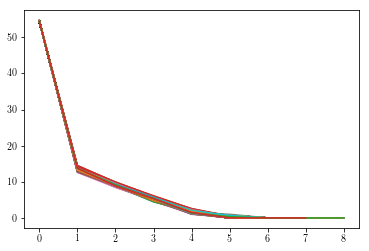

In [53]:
for temp in frac_sat_arr:
    plt.plot(temp)

In [54]:
np.nanpercentile(frac_sat_arr, 68, axis=0)

array([54.36747531, 13.5430262 ,  9.2626432 ,  5.35062566,  1.81043663,
        0.33898305,  0.        ,  0.        ,  0.        ])

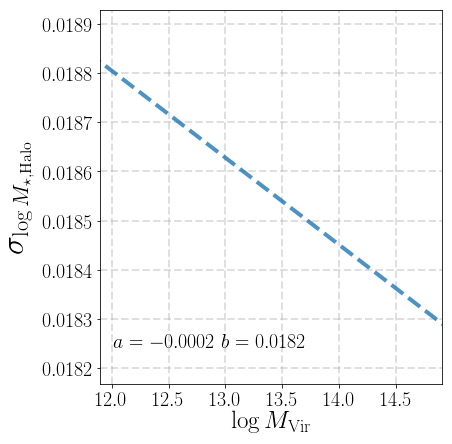

In [55]:
min_scatter = 0.01

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.205, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

logmh_cen = np.linspace(11.5, 15.4, 1000)
sig_ms = sigms_a * (np.asarray(logmh_cen) - 15.3) + sigms_b
sig_ms = np.where(sig_ms <= min_scatter, min_scatter, sig_ms)

ax1.plot(logmh_cen, sig_ms,
         linewidth=4.0, linestyle='--', alpha=0.8)

ax1.text(0.32, 0.09, r"$a=%7.4f\ b=%7.4f$" % (sigms_a, sigms_b),
         verticalalignment='bottom',
         horizontalalignment='center',
         fontsize=20,
         transform=ax1.transAxes)

ax1.set_xlim(11.9, 14.9)

ax1.set_xlabel(r'$\log M_{\mathrm{Vir}}$', fontsize=25)
ax1.set_ylabel(r'$\sigma_{\log M_{\star, \rm Halo}}$',
               fontsize=32)

fig.savefig(os.path.join('fig', model_str + '_shmr_scatter.pdf'), dpi=150)

(2, 8)

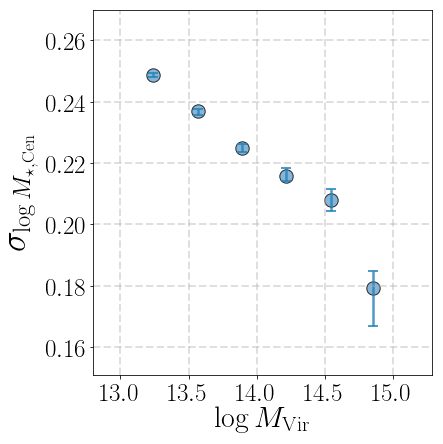

In [66]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.21, right=0.995,
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
ax1.scatter(logmh_mean, sigms_cen, s=180, alpha=0.8, edgecolor='k',
            facecolor=BLU(0.7))

yerr = np.stack([np.nanmax(sigms_cen_arr, axis=0) - sigms_cen,
                 sigms_cen - np.nanmin(sigms_cen_arr, axis=0)])
ax1.errorbar(logmh_mean, sigms_cen, yerr=yerr, 
             fmt='o', ecolor=BLU(0.9), elinewidth=2.5, capsize=5, capthick=2.0,
             color=BLU(0.9), markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1)

ax1.set_xlim(12.8, 15.29)
ax1.set_ylim(0.151, 0.27)

ax1.set_xlabel(r'$\log M_{\mathrm{Vir}}$', fontsize=30)
ax1.set_ylabel(r'$\sigma_{\log M_{\star, \rm Cen}}$',
               fontsize=35)

fig.savefig(os.path.join('fig', model_str + '_mhalo_sigms.pdf'), dpi=150)

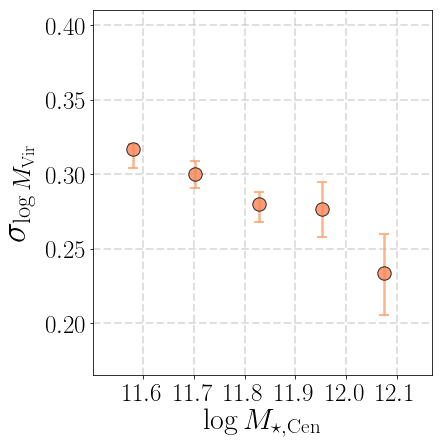

In [73]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.21, right=0.995,
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

ax1.scatter(logms_mean, sigmh_all, c=ORG(0.6), 
            s=180, alpha=0.8, edgecolor='k', zorder=2)

yerr = np.stack([np.nanmax(sigmh_all_arr, axis=0) - sigmh_all,
                 sigmh_all - np.nanmin(sigmh_all_arr, axis=0)])
ax1.errorbar(logms_mean, sigmh_all, yerr=yerr, 
             fmt='o', ecolor=ORG(0.5), elinewidth=2.5, capsize=5, capthick=2.0,
             color=ORG(0.5), markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1)

ax1.set_xlim(11.501, 12.17)
ax1.set_ylim(0.165, 0.41)

ax1.set_xlabel(r'$\log M_{\star, \mathrm{Cen}}$', fontsize=30)
ax1.set_ylabel(r'$\sigma_{\log M_{\rm Vir}}$',
               fontsize=35)

fig.savefig(os.path.join('fig', model_str + '_mstar_sigmh.pdf'), dpi=150)

#### Satellite fraction

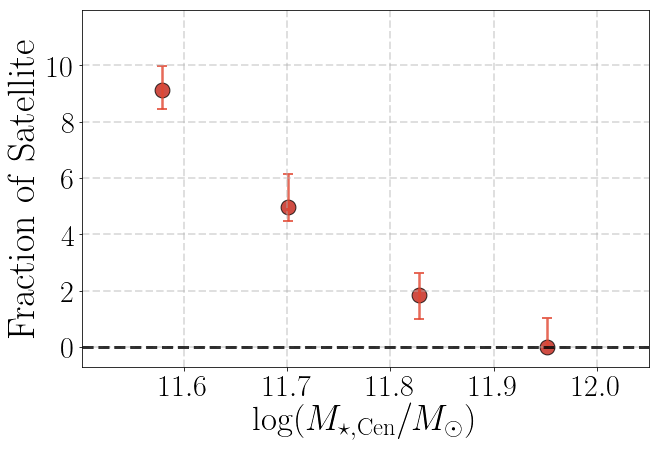

In [71]:
fig = plt.figure(figsize=(9, 6))
fig.subplots_adjust(left=0.12, right=0.995,
                    bottom=0.17, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

ax1.scatter(logms_mean, frac_sat, c=ORG(0.9), 
            s=220, alpha=0.8, edgecolor='k')

yerr = np.stack([frac_sat - np.nanmin(frac_sat_arr, axis=0),
                 np.nanmax(frac_sat_arr, axis=0) - frac_sat])
ax1.errorbar(logms_mean, frac_sat, yerr=yerr, 
             fmt='o', ecolor=ORG(0.8), elinewidth=2.5, capsize=5, capthick=2.0,
             color=ORG(0.8), markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1)

ax1.set_xlim(11.501, 12.05)
ax1.set_ylim(-0.7, 11.95)

ax1.axhline(0.0, linestyle='--', linewidth=3.0, c='k', alpha=0.8)

ax1.set_xlabel(r'$\log (M_{\star, \mathrm{Cen}}/M_{\odot})$', fontsize=35)
ax1.set_ylabel(r'$\mathrm{Fraction\ of\ Satellite}$',
               fontsize=38)

fig.savefig(os.path.join('fig', model_str + '_frac_sat.pdf'), dpi=150)

#### For figures used in publication

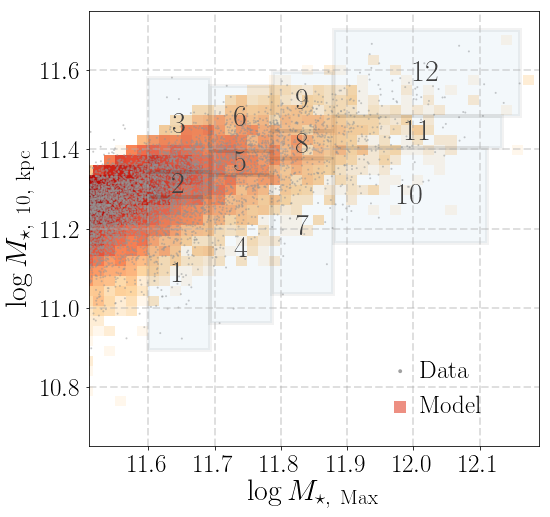

In [86]:
fig = plt.figure(figsize=(7.5, 7))

fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

## M100-M10 scatter plot
mask_mod = ((logms_tot_mod_all >= 11.45) & 
            (logms_tot_mod_all <= 12.20) & 
            (logms_inn_mod_all >= 10.65) & 
            (logms_inn_mod_all <= 11.70))

x_arr = logms_tot_mod_all[mask_mod]
y_arr = logms_inn_mod_all[mask_mod]
z_arr = um_mock['logmh_peak'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, 'count', bins=(45, 40))

z_img = z_stats.T
z_img[z_img <= 1] = 0
HM = ax1.imshow(np.log10(z_img), origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                aspect='auto', interpolation='nearest',
                cmap='OrRd', label=r'$\mathrm{Model}$')

ax1.scatter(obs_use['logm_max'], obs_use['logm_10'], s=4, alpha=0.5, 
            facecolor=BLK(0.5), edgecolor='none', label=r'$\mathrm{Data}$')

ax1.scatter(11.98, 10.84, marker='o', facecolor=BLK(0.6), s=15, edgecolor='None',
            alpha=0.7)
ax1.text(12.01, 10.84, r'$\mathrm{Data}$', fontsize=25, 
         horizontalalignment='left', verticalalignment='center')

ax1.scatter(11.98, 10.75, marker='s', facecolor=ORG(0.8), s=150, edgecolor='None',
            alpha=0.6)
ax1.text(12.01, 10.75, r'$\mathrm{Model}$', fontsize=25, 
         horizontalalignment='left', verticalalignment='center')

_ = ax1.set_xlim(11.51, 12.19)
_ = ax1.set_ylim(10.65, 11.75)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=30)

for ii in np.arange(12):
    obs_prof = obs_dsigma[ii]
    ax1.add_patch(
        patches.Rectangle(
            (obs_prof.low_mtot, obs_prof.low_minn),
            (obs_prof.upp_mtot - obs_prof.low_mtot),
            (obs_prof.upp_minn - obs_prof.low_minn), 
            alpha=0.05, edgecolor='k', linewidth=4))
    ax1.text((obs_prof.upp_mtot + obs_prof.low_mtot) / 2.0, 
             (obs_prof.upp_minn + obs_prof.low_minn) / 2.0,
             "%d" % (ii + 1), 
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=30, color=BLK(0.8))

fig.savefig('fig/mmax_m10_density_wlbin.pdf', dpi=150)

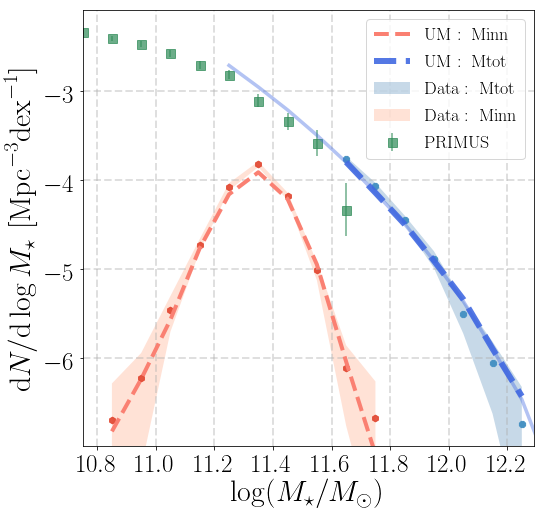

In [87]:
fig = plt.figure(figsize=(7.5, 7))

fig.subplots_adjust(left=0.16, right=0.995,
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

obs_smf_tot = obs_data['obs_smf_tot']
obs_smf_inn = obs_data['obs_smf_inn']
obs_logms_tot = obs_data['obs_mtot']
obs_logms_inn = obs_data['obs_minn']
obs_smf_full = obs_data['obs_smf_full']
not_table = True

um_smf_tot_all = get_smf_bootstrap(logms_tot_mod_all, cfg['um_volume'],
                                   20, 10.5, 12.5, n_boots=1)
um_smf_tot_all=um_smf_tot_all[7:]

if obs_smf_full is not None:
    ax1.errorbar(obs_smf_full['logm_mean'] + 0.15,
                 np.log10(obs_smf_full['smf']),
                 (np.log10(obs_smf_full['smf_upp']) -
                  np.log10(obs_smf_full['smf'])),
                 fmt='o', color='seagreen',
                 ecolor='seagreen',
                 alpha=0.7, marker='s',
                 markersize=9,
                 label=r'$\mathrm{PRIMUS}$',
                 zorder=0)

if um_smf_tot_all is not None:
    ax1.plot(um_smf_tot_all['logm_mean'],
             np.log10(um_smf_tot_all['smf']),
             linewidth=3.5, linestyle='-',
             c='royalblue', alpha=0.4,
             label='__no_label__')

# SMF plot
ax1.fill_between(obs_smf_tot['logm_mean'],
                 np.log10(obs_smf_tot['smf_low']),
                 np.log10(obs_smf_tot['smf_upp']),
                 facecolor='steelblue',
                 edgecolor='none',
                 interpolate=True,
                 alpha=0.3,
                 label=r'$\mathrm{Data:\ Mtot}$')

ax1.fill_between(obs_smf_inn['logm_mean'],
                 np.log10(obs_smf_inn['smf_low']),
                 np.log10(obs_smf_inn['smf_upp']),
                 facecolor='lightsalmon',
                 edgecolor='none',
                 interpolate=True,
                 alpha=0.3,
                 label=r'$\mathrm{Data:\ Minn}$')

ax1.scatter(obs_smf_inn['logm_mean'],
            np.log10(obs_smf_inn['smf']),
            marker='h',
            c=ORG(0.8),
            s=45, label='__no_label__',
            alpha=0.9)

ax1.scatter(obs_smf_tot['logm_mean'],
            np.log10(obs_smf_tot['smf']),
            marker='8',
            c=BLU(0.8),
            s=45, label='__no_label__',
            alpha=1.0)

if isinstance(um_smf_inn, (list,)):
    for ii, smf in enumerate(um_smf_inn):
        if ii == 0:
            if not_table:
                ax1.plot(obs_smf_inn['logm_mean'],
                         np.log10(smf),
                         linewidth=1, linestyle='-',
                         c='salmon', alpha=0.7,
                         label=r'$\mathrm{UM:\ Minn}$')
            else:
                ax1.plot(smf['logm_mean'],
                         np.log10(smf['smf']),
                         linewidth=1, linestyle='-',
                         c='salmon', alpha=0.7,
                         label=r'$\mathrm{UM:\ Minn}$')
        else:
            if not_table:
                ax1.plot(obs_smf_inn['logm_mean'],
                         np.log10(smf),
                         linewidth=1, linestyle='-',
                         c='salmon', alpha=0.7,
                         label='__no_label__')
            else:
                ax1.plot(smf['logm_mean'],
                         np.log10(smf['smf']),
                         linewidth=1, linestyle='-',
                         c='salmon', alpha=0.7,
                         label='__no_label__')
else:
    if not_table:
        ax1.plot(obs_smf_inn['logm_mean'],
                 np.log10(um_smf_inn),
                 linewidth=4, linestyle='--',
                 c='salmon',
                 label=r'$\mathrm{UM:\ Minn}$')
    else:
        ax1.plot(um_smf_inn['logm_mean'],
                 np.log10(um_smf_inn['smf']),
                 linewidth=4, linestyle='--',
                 c='salmon',
                 label=r'$\mathrm{UM:\ Minn}$')

if isinstance(um_smf_tot, (list,)):
    for ii, smf in enumerate(um_smf_tot):
        if ii == 0:
            if not_table:
                ax1.plot(obs_smf_tot['logm_mean'],
                         np.log10(smf),
                         linewidth=1, linestyle='-',
                         c='royalblue', alpha=0.7,
                         label=r'$\mathrm{UM:\ Mtot}$')
            else:
                ax1.plot(smf['logm_mean'],
                         np.log10(smf['smf']),
                         linewidth=1, linestyle='-',
                         c='royalblue', alpha=0.7,
                         label=r'$\mathrm{UM:\ Mtot}$')
        else:
            if not_table:
                ax1.plot(obs_smf_tot['logm_mean'],
                         np.log10(smf),
                         linewidth=1, linestyle='-',
                         c='royalblue', alpha=0.7,
                         label='__no_label__')
            else:
                ax1.plot(smf['logm_mean'],
                         np.log10(smf['smf']),
                         linewidth=1, linestyle='-',
                         c='royalblue', alpha=0.7,
                         label='__no_label__')
else:
    if not_table:
        ax1.plot(obs_smf_tot['logm_mean'],
                 np.log10(um_smf_tot),
                 linewidth=6, linestyle='--',
                 c='royalblue', alpha=0.9,
                 label=r'$\mathrm{UM:\ Mtot}$')
    else:
        ax1.plot(um_smf_tot['logm_mean'],
                 np.log10(um_smf_tot['smf']),
                 linewidth=6, linestyle='--',
                 c='royalblue', alpha=0.9,
                 label=r'$\mathrm{UM:\ Mtot}$')

ax1.legend(fontsize=18, loc='upper right')

ax1.set_xlabel(r'$\log (M_{\star}/M_{\odot})$',
               fontsize=30)
ax1.set_ylabel((r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ $'
                r'$[{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'),
               size=30)

mask_inn = np.log10(obs_smf_inn['smf']) > -7.5
mask_tot = np.log10(obs_smf_tot['smf']) > -7.5

_ = ax1.set_xlim(10.75, 12.29)
_ = ax1.set_ylim(-6.99, -2.09)

fig.savefig('fig/mmax_m10_mod_smfs.pdf', dpi=150)

#### Fraction of the In-situ and ex-situ stars in the inner 10 kpc

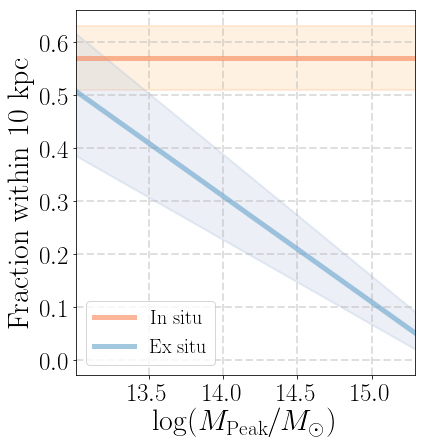

In [90]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.21, right=0.995,
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
ax1.fill_between([12.5, 15.7], [0.51, 0.51], [0.63, 0.63],
                 facecolor=ORG(0.3), edgecolor=ORG(0.4), linewidth=2,
                 alpha=0.3, label='__no_label__')
ax1.axhline(0.57, linestyle='-', linewidth=5.0, alpha=0.6, c=ORG(0.6),
            label=r'$\mathrm{In\ situ}$')

logmh_arr = np.linspace(13.0, 15.4, 100)
exsitu_frac_0 = -0.20 * (logmh_arr - 15.3) + 0.05
exsitu_frac_1 = -0.16 * (logmh_arr - 15.3) + 0.02
exsitu_frac_2 = -0.23 * (logmh_arr - 15.3) + 0.09

ax1.fill_between(logmh_arr, exsitu_frac_1, exsitu_frac_2,
                 facecolor=BLU(0.3), edgecolor=BLU(0.4), linewidth=2,
                 alpha=0.3, label='__no_label__')
ax1.plot(logmh_arr, exsitu_frac_0, linewidth=5.0, alpha=0.6, c=BLU(0.7),
         label=r'$\mathrm{Ex\ situ}$')

ax1.set_xlim(13.01, 15.29)
#ax1.set_ylim(0.165, 0.41)

ax1.legend(loc='lower left', fontsize=20)

ax1.set_xlabel(r'$\log (M_{\mathrm{Peak}}/M_{\odot})$', fontsize=30)
ax1.set_ylabel(r'$\mathrm{Fraction\ within\ 10\ kpc}$',
               fontsize=30)

fig.savefig(os.path.join('fig', model_str + '_mhalo_frac_10kpc.pdf'), dpi=120)

#### In-situ and ex-situ mass in 10 kpc, and its relation with M_max

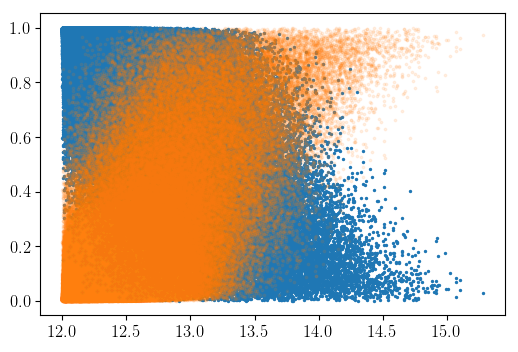

In [384]:
plt.scatter(um_mock[mask_cen]['logmh_peak'], frac_ins, s=2)
plt.scatter(um_mock[mask_cen]['logmh_peak'], frac_exs, s=3, alpha=0.1)

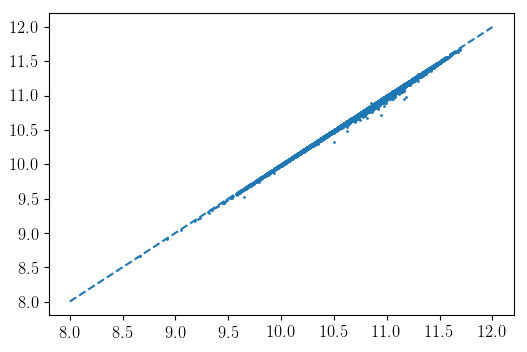

In [388]:
plt.scatter(logms_inn_mod_all[mask_cen], 
            np.log10(10.0 ** logms_mod_ins_10kpc + 10.0 ** logms_mod_exs_10kpc),
            s=1)

plt.plot([8.0, 12.0], [8.0, 12.0], linestyle='--')

In [391]:
um_mock.dtype

dtype([('upid', '<i8'), ('sm', '<f8'), ('icl', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('mtot_galaxy', '<f8'), ('mstar_mhalo', '<f8'), ('logms_gal', '<f8'), ('logms_icl', '<f8'), ('logms_tot', '<f8'), ('logms_halo', '<f8'), ('logmh_vir', '<f8'), ('logmh_peak', '<f8'), ('logmh_host', '<f8'), ('frac_cen_tot', '<f8'), ('frac_ins_cen', '<f8'), ('frac_exs_cen', '<f8')])

In [98]:
mask_cen = um_mock['upid'] == -1

frac_ins = um_mock[mask_cen]['sm'] / um_mock[mask_cen]['mtot_galaxy']
frac_exs = um_mock[mask_cen]['icl'] / um_mock[mask_cen]['mtot_galaxy']

logms_mod_ins_all = logms_tot_mod_all[mask_cen] + np.log10(frac_ins)
logms_mod_exs_all = logms_tot_mod_all[mask_cen] + np.log10(frac_exs)

logms_mod_ins_10kpc = (logms_mod_ins_all + np.log10(0.57))
logms_mod_exs_10kpc = (logms_mod_exs_all + 
                       np.log10(-0.20 * (logmh_peak[mask_cen] - 15.3) + 0.05))

frac_exs_10kpc = ((10.0 ** logms_mod_exs_10kpc) / 
                  (10.0 ** logms_mod_ins_10kpc + 10.0 ** logms_mod_exs_10kpc))

In [99]:
logms_bin = np.linspace(11.4, 12.3, 11)

# For central
idx_logms_cen = np.digitize(logms_tot_mod_all[mask_cen], logms_bin)

avg_mass = np.asarray([np.nanmean(logms_tot_mod_all[mask_cen][idx_logms_cen == k])
                       for k in range(len(logms_bin))])

avg_frac = np.asarray([np.nanmean(frac_exs[idx_logms_cen == k])
                       for k in range(len(logms_bin))])

f16_frac = np.asarray([np.nanpercentile(frac_exs[idx_logms_cen == k], 16)
                       for k in range(len(logms_bin))])

f84_frac = np.asarray([np.nanpercentile(frac_exs[idx_logms_cen == k], 84)
                       for k in range(len(logms_bin))])

avg_frac_10kpc = np.asarray([np.nanmean(frac_exs_10kpc[idx_logms_cen == k])
                             for k in range(len(logms_bin))])

f16_frac_10kpc = np.asarray([np.nanpercentile(frac_exs_10kpc[idx_logms_cen == k], 16)
                             for k in range(len(logms_bin))])

f84_frac_10kpc = np.asarray([np.nanpercentile(frac_exs_10kpc[idx_logms_cen == k], 84)
                             for k in range(len(logms_bin))])

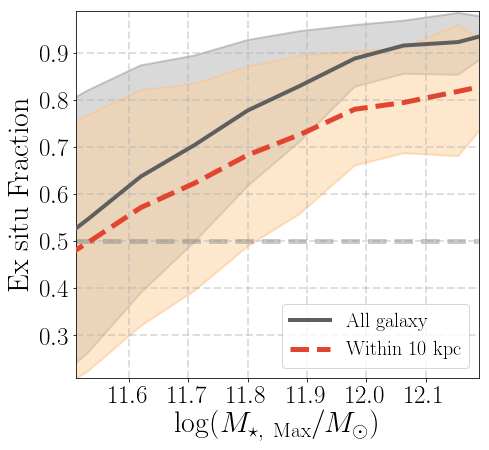

In [100]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.195, right=0.995,
                    bottom=0.145, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
ax1.axhline(0.5, linewidth=5.0, alpha=0.4, c=BLK(0.6), linestyle='--')    

ax1.fill_between(avg_mass, f16_frac, f84_frac,
                 facecolor=BLK(0.4), edgecolor=BLK(0.5), linewidth=2,
                 alpha=0.5, label='__no_label__', zorder=0)

ax1.fill_between(avg_mass, f16_frac_10kpc, f84_frac_10kpc,
                 facecolor=ORG(0.3), edgecolor=ORG(0.4), linewidth=2,
                 alpha=0.5, label='__no_label__', zorder=1)
    
ax1.plot(avg_mass, avg_frac, linestyle='-', c=BLK(0.7), linewidth=4.0,
         label=r'$\mathrm{All\ galaxy}$', zorder=10)

ax1.plot(avg_mass, avg_frac_10kpc, linestyle='--', c=ORG(0.8), linewidth=5.0,
         label=r'$\mathrm{Within\ 10\ kpc}$', zorder=11)

ax1.set_xlim(11.51, 12.19)
ax1.set_ylim(0.21, 0.99)

ax1.legend(loc='lower right', fontsize=20)

_ = ax1.set_xlabel(r'$\log (M_{\star,\ \mathrm{Max}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\mathrm{Ex\ situ\ Fraction}$', fontsize=30)

fig.savefig(os.path.join('fig', model_str + '_logms_frac_exs.pdf'), dpi=150)

In [101]:
logmh_bin = np.linspace(12.4, 15.4, 15)

# For central
idx_logmh_cen = np.digitize(logmh_peak[mask_cen], logmh_bin)

avg_mass = np.asarray([np.nanmean(logmh_peak[mask_cen][idx_logmh_cen == k])
                       for k in range(len(logmh_bin))])

avg_frac = np.asarray([np.nanmean(frac_exs[idx_logmh_cen == k])
                       for k in range(len(logmh_bin))])

f16_frac = np.asarray([np.nanpercentile(frac_exs[idx_logmh_cen == k], 16)
                       for k in range(len(logmh_bin))])

f84_frac = np.asarray([np.nanpercentile(frac_exs[idx_logmh_cen == k], 84)
                       for k in range(len(logmh_bin))])

avg_frac_10kpc = np.asarray([np.nanmean(frac_exs_10kpc[idx_logmh_cen == k])
                             for k in range(len(logmh_bin))])

f16_frac_10kpc = np.asarray([np.nanpercentile(frac_exs_10kpc[idx_logmh_cen == k], 16)
                             for k in range(len(logmh_bin))])

f84_frac_10kpc = np.asarray([np.nanpercentile(frac_exs_10kpc[idx_logmh_cen == k], 84)
                             for k in range(len(logmh_bin))])

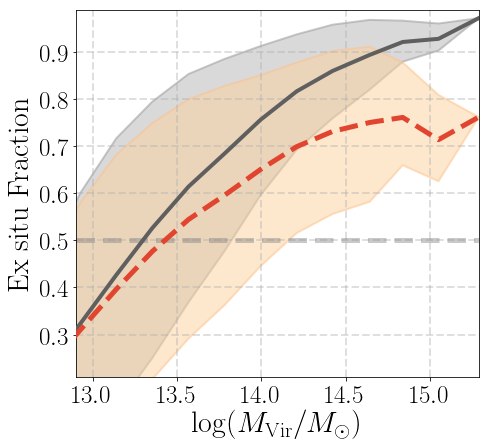

In [102]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.195, right=0.995,
                    bottom=0.145, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
ax1.axhline(0.5, linewidth=5.0, alpha=0.4, c=BLK(0.6), linestyle='--')    

ax1.fill_between(avg_mass, f16_frac, f84_frac,
                 facecolor=BLK(0.4), edgecolor=BLK(0.5), linewidth=2,
                 alpha=0.5, label='__no_label__', zorder=0)

ax1.fill_between(avg_mass, f16_frac_10kpc, f84_frac_10kpc,
                 facecolor=ORG(0.3), edgecolor=ORG(0.4), linewidth=2,
                 alpha=0.5, label='__no_label__', zorder=1)
    
ax1.plot(avg_mass, avg_frac, linestyle='-', c=BLK(0.7), linewidth=4.0,
         label=r'$\mathrm{All\ galaxy}$', zorder=10)

ax1.plot(avg_mass, avg_frac_10kpc, linestyle='--', c=ORG(0.8), linewidth=5.0,
         label=r'$\mathrm{Within\ 10\ kpc}$', zorder=11)

ax1.set_xlim(12.90, 15.29)
ax1.set_ylim(0.21, 0.99)

#ax1.legend(loc='lower right', fontsize=20)

_ = ax1.set_xlabel(r'$\log (M_{\mathrm{Vir}}/M_{\odot})$', fontsize=30)
_ = ax1.set_ylabel(r'$\mathrm{Ex\ situ\ Fraction}$', fontsize=30)

fig.savefig(os.path.join('fig', model_str + '_logmh_frac_exs.pdf'), dpi=150)